In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Hyper Parameters
BATCH_SIZE = 100
LR_G = 0.0001           # learning rate for generator
LR_D = 0.0001           # learning rate for discriminator
N_IDEAS = 5             # think of this as number of ideas for generating an art work (Generator)
ART_COMPONENTS = 15     # it could be total point G can draw in the canvas

In [3]:
PAINT_POINTS = []
for _ in range(0 , BATCH_SIZE):
    PAINT_POINTS.append(np.linspace(-1 , 1 , ART_COMPONENTS))
PAINT_POINTS = np.array(PAINT_POINTS)   

def artist_works():     # painting from the famous artist (real target)
    a = np.random.uniform(1 , 2 , size = BATCH_SIZE).reshape(-1 , 1)
    paintings , match = [] , np.zeros((BATCH_SIZE , 2))
    for i in range(0 , BATCH_SIZE):
        paintings.append(a[i , 0] * PAINT_POINTS[i , :] ** 2 + a[i , 0] - 1)
        if a[i , 0] >= 1.5:   # a[i , 0] >= 1.5 ⟹ 代表第1種condition
            match[i , 0] = 0
            match[i , 1] = 1
        elif a[i , 0] < 1.5:  # a[i , 0] < 1.5 ⟹ 代表第2種condition 
            match[i , 0] = 1
            match[i , 1] = 0           
    paintings = np.array(paintings)
    
    # 選定match裡頭不為1的index，隨機從這些index選一個，接著將填一個1進去
    # 這一筆data的match ➝ [0 , 0 , 1 , 0 , 0] 
    # 從[0 , 1 , 3 , 4]這些index中隨機選一個，假設選出3
    # 這一筆data相對應的mismatch ➝ [0 , 0 , 0 , 1 , 0] 
    mismatch = np.zeros(match.shape) 
    for i in range(0 , BATCH_SIZE):
        match_index = np.where(match[i , :] == 1)
        while True:
            mismatch_index = np.random.randint(0 , 2) 
            if mismatch_index != match_index : break
        mismatch[i , mismatch_index] = 1
    
    return paintings , match , mismatch

In [4]:
def add_layer(inputs , in_size , out_size , activaction_function = None): 
    Weights = tf.get_variable(initializer = tf.truncated_normal([in_size , out_size] , mean = 0.001 , stddev = 0.3) , name = 'w_a')
    biases = tf.get_variable(initializer = tf.zeros([1 , out_size]) + 0.001 , name = 'b_a')
    Wx_plus_b = tf.add(tf.matmul(inputs , Weights) , biases) 

    # here to activaction_function
    if activaction_function is None:
        outputs = Wx_plus_b
    else:
        outputs = activaction_function(Wx_plus_b , name = 'output')
        
    return outputs 

In [5]:
# define placeholder for inputs to network
art_match = tf.placeholder(tf.float32 , [None , 2])
art_mismatch = tf.placeholder(tf.float32 , [None , 2])
xs_G = tf.placeholder(tf.float32 , [None , N_IDEAS])
xs_D = tf.placeholder(tf.float32 , [None , ART_COMPONENTS])

In [6]:
# Generator，相當於偽造家
with tf.variable_scope('Generator'):
    with tf.variable_scope('hidden_layer'):
        xs_G_condition = tf.concat([xs_G , art_match] , axis = 1)
        layer_G = add_layer(xs_G_condition ,  N_IDEAS + 2 , 128 , activaction_function = tf.nn.relu)
    
    with tf.variable_scope('output_layer'):
        G_out = add_layer(layer_G , 128 , ART_COMPONENTS , activaction_function = None)          
        

# Discriminator，相當於鑑定師  
with tf.variable_scope('Discriminator'): 
    with tf.variable_scope('hidden_layer'): 
        G_out_condition = tf.concat([G_out , art_match] , axis = 1)
        layer_D_for_G = add_layer(G_out_condition , ART_COMPONENTS + 2 , 128 , activaction_function = tf.nn.relu)
        tf.get_variable_scope().reuse_variables() 
        
        xs_D_match = tf.concat([xs_D , art_match] , axis = 1)
        layer_D_for_D_match = add_layer(xs_D_match , ART_COMPONENTS + 2 , 128 , activaction_function = tf.nn.relu) 
        
        xs_D_mismatch = tf.concat([xs_D , art_mismatch] , axis = 1)
        layer_D_for_D_mismatch = add_layer(xs_D_mismatch , ART_COMPONENTS + 2 , 128 , activaction_function = tf.nn.relu) 
    
    with tf.variable_scope('output_layer'): 
        # 以鑑定師D的角度來看，會希望將偽造品鑑定為真品的機率越小越好，也就是希望prob_artist_for_G越小越好
        # 但是以偽造家G的角度來看，會希望將偽造品鑑定為真品的機率越大越好，也就是希望prob_artist_for_G越大越好
        prob_artist_for_G = add_layer(layer_D_for_G , 128 , 1 , activaction_function = tf.nn.sigmoid)  # 以D的角度來看，希望這一項越小越好;但是以G的角度來看，會希望這一項越大越好
        tf.get_variable_scope().reuse_variables()
        
        # 以鑑定師D的角度來看，會希望原來就是真品鑑定為真品，並且搭配正確的condition，這種組合的機率越大越好
        # 也就是希望prob_artist_for_D_match越大越好
        prob_artist_for_D_match = add_layer(layer_D_for_D_match , 128 , 1 , activaction_function = tf.nn.sigmoid)  
        
        # 以鑑定師D的角度來看，雖然會希望原來就是真品鑑定為真品，但是搭配不正確的condition，這種組合的機率越小越好
        # 也就是希望prob_artist_for_D_mismatch越小越好
        prob_artist_for_D_mismatch = add_layer(layer_D_for_D_mismatch , 128 , 1 , activaction_function = tf.nn.sigmoid)  

In [7]:
# 偽造家G會希望prob_artist_for_D越大越好，等同於(1. - prob_artist_for_G)越小越好
# 所以G_loss確實會越來越小
G_loss = tf.reduce_mean(tf.log(1. - prob_artist_for_G) , 0)[0]  

# 鑑定師D會希望prob_artist_for_G越小越好，等同於 -(1. - prob_artist_for_G) 越小越好
# 鑑定師D也會希望prob_artist_for_D_mismatc越小越好，等同於 -(1. - prob_artist_for_D_mismatch) 越小越好
# 鑑定師D也會希望prob_artist_for_D_match越大越好，等同於 -prob_artist_for_D_match 越小越好
# 所以D_loss會越來越小
D_loss =  -tf.reduce_mean(tf.log(1. - prob_artist_for_G)  + tf.log(1. - prob_artist_for_D_mismatch) + tf.log(prob_artist_for_D_match) , 0)[0]

In [8]:
# 這個步驟很重要!!
# 訓練Generator與Discriminator時，兩者的參數分開來訓練會比較容易訓練
# 訓練Generator時，凍結Discriminator的參數
# 訓練Discriminator時，凍結Generator的參數
variable_Generator , variable_Discriminator = [] , []
for i in tf.trainable_variables(): 
    if 'Generator' in i.name : variable_Generator.append(i)
    if 'Discriminator' in i.name : variable_Discriminator.append(i)
train_Generator = tf.train.AdamOptimizer(LR_G).minimize(G_loss , var_list = variable_Generator)
train_Discriminator = tf.train.AdamOptimizer(LR_D).minimize(D_loss , var_list = variable_Discriminator)
train_op = tf.group([train_Generator , train_Discriminator])

In [9]:
sess = tf.Session() 
sess.run(tf.global_variables_initializer())

G_paintings_list = []
match_list = []
for step in range(0 , 15000):
    artist_paintings , match , mismatch = artist_works()
    match = match.astype(np.float32)
    mistch = mismatch.astype(np.float32)
    G_ideas = np.random.rand(BATCH_SIZE , N_IDEAS)
    
    _ , G_loss_ , D_loss_ = sess.run([train_op , G_loss , D_loss] , feed_dict = {xs_G : G_ideas , 
                                                                                 xs_D : artist_paintings , 
                                                                                 art_match : match , 
                                                                                 art_mismatch : mismatch})
    
    if step % 300 == 0:
        print('=' * 30)
        print('step : {}'.format(step))
        print('G_loss : {:.2f} , D_loss : {:.2f}'.format(G_loss_ , D_loss_))
    
    if step % 625 == 0:
        G_paintings = sess.run(G_out , feed_dict = {xs_G : G_ideas , art_match : match})
        G_paintings_list.append(G_paintings[0 , :])
        match_list.append(match[0 , :])

step : 0
G_loss : -0.81 , D_loss : 2.58
step : 300
G_loss : -0.33 , D_loss : 1.68
step : 600
G_loss : -0.12 , D_loss : 1.42
step : 900
G_loss : -0.23 , D_loss : 1.60
step : 1200
G_loss : -0.11 , D_loss : 1.35
step : 1500
G_loss : -0.17 , D_loss : 1.41
step : 1800
G_loss : -0.21 , D_loss : 1.40
step : 2100
G_loss : -0.25 , D_loss : 1.45
step : 2400
G_loss : -0.30 , D_loss : 1.53
step : 2700
G_loss : -0.43 , D_loss : 1.65
step : 3000
G_loss : -0.45 , D_loss : 1.76
step : 3300
G_loss : -0.42 , D_loss : 1.69
step : 3600
G_loss : -0.45 , D_loss : 1.77
step : 3900
G_loss : -0.45 , D_loss : 1.75
step : 4200
G_loss : -0.46 , D_loss : 1.77
step : 4500
G_loss : -0.46 , D_loss : 1.74
step : 4800
G_loss : -0.46 , D_loss : 1.75
step : 5100
G_loss : -0.48 , D_loss : 1.74
step : 5400
G_loss : -0.47 , D_loss : 1.76
step : 5700
G_loss : -0.47 , D_loss : 1.75
step : 6000
G_loss : -0.47 , D_loss : 1.73
step : 6300
G_loss : -0.46 , D_loss : 1.73
step : 6600
G_loss : -0.47 , D_loss : 1.72
step : 6900
G_los

#### condition 1&nbsp; ⟹ a >= 1.5 &nbsp;  &nbsp;以紅色線代表
#### condition 2&nbsp; ⟹ a < 1.5&nbsp; &nbsp;  &nbsp;以綠色線代表

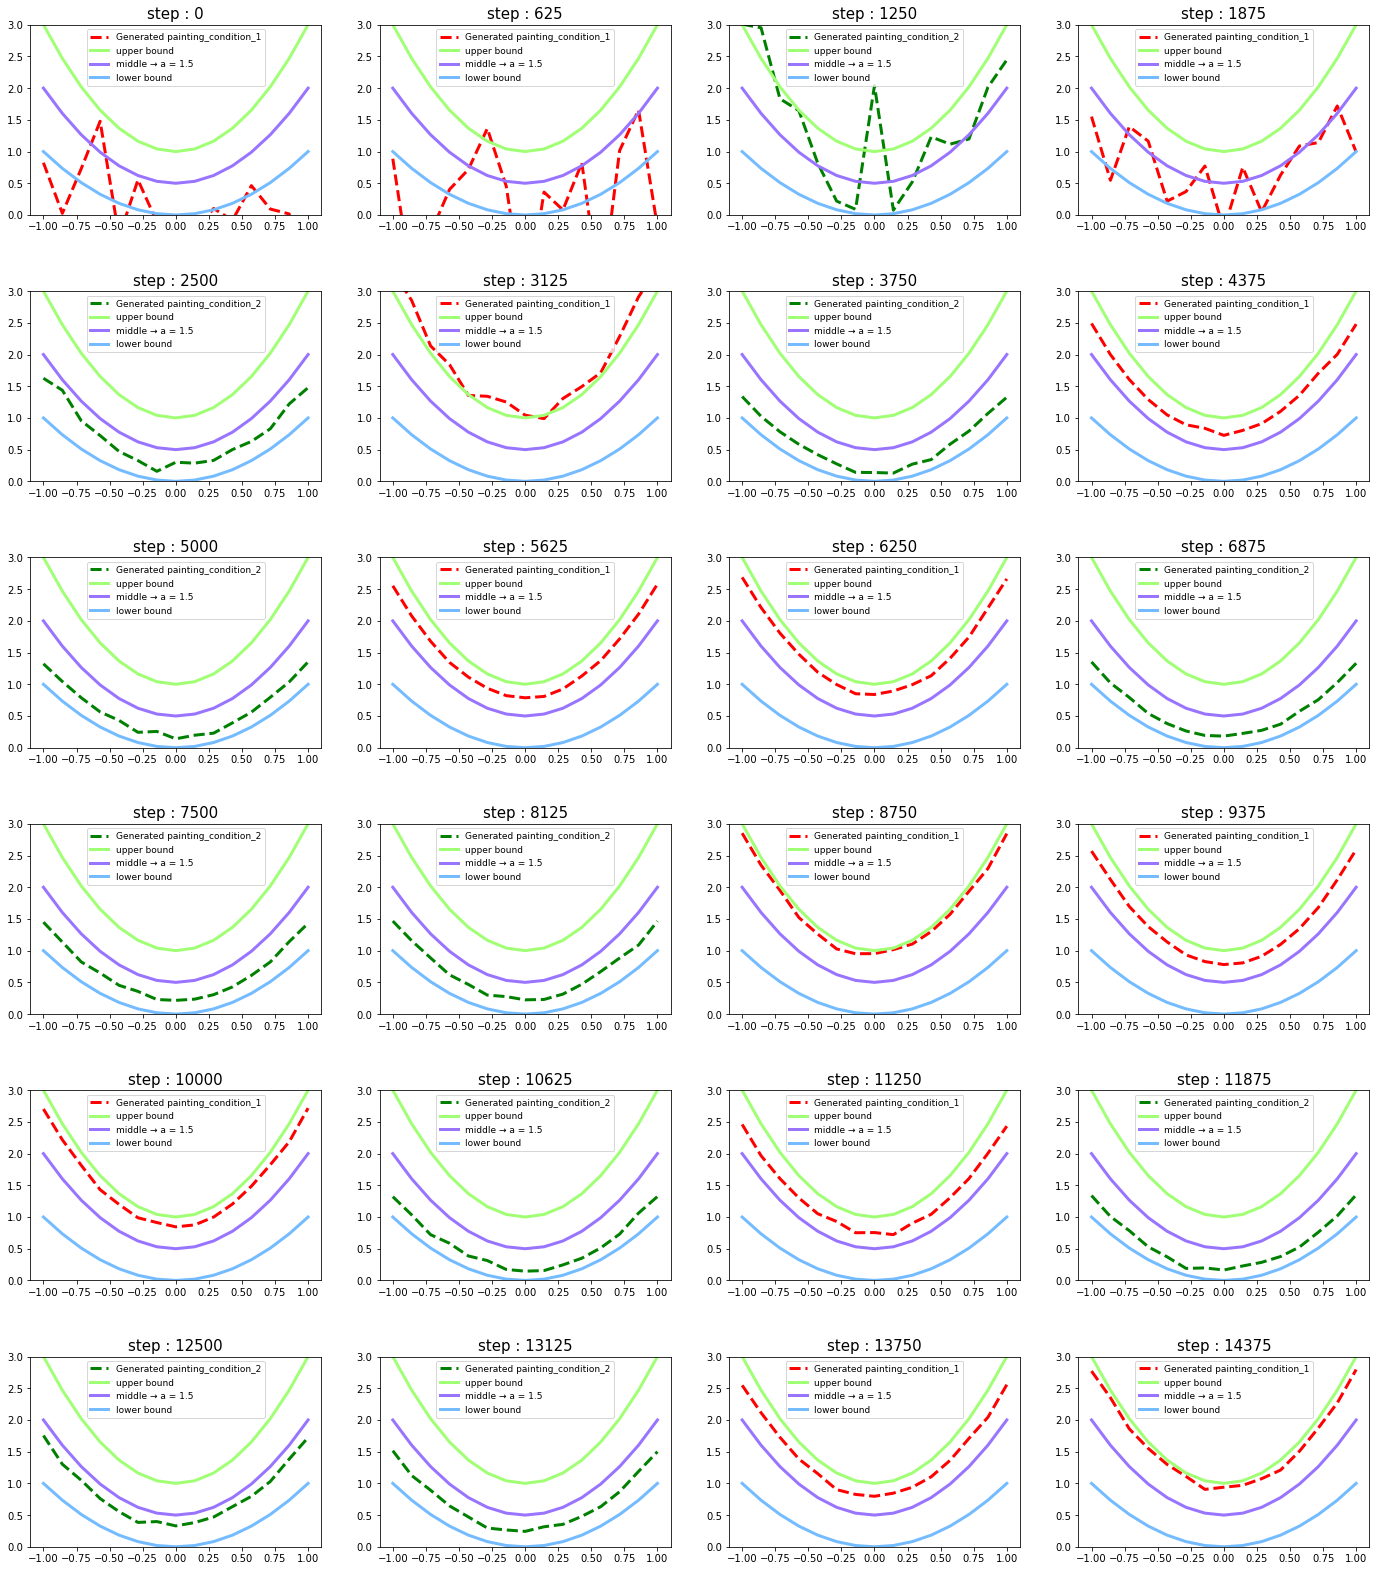

In [10]:
fig , ax = plt.subplots(6 , 4 , figsize = (24 , 28))
plt.subplots_adjust(wspace = 0.2 , hspace = 0.4)

for i in range(0 , 6):
    for j in range(0 , 4):
        
        G_paintings = G_paintings_list[4 * i + j]
        match = match_list[4 * i + j]
        
        if match[0] == 0 and match[1] == 1:
            ax[i , j].plot(PAINT_POINTS[0 , :] , G_paintings , c = 'r' , lw = 3 , ls = '--' , label = 'Generated painting_condition_1')
        if match[0] == 1 and match[1] == 0:
            ax[i , j].plot(PAINT_POINTS[0 , :] , G_paintings , c = 'g' , lw = 3 , ls = '--' , label = 'Generated painting_condition_2') 

        ax[i , j].plot(PAINT_POINTS[0 , :] , 2 * np.power(PAINT_POINTS[0 , :] , 2) + 1 , c = '#a0ff74' , lw = 3 , label = 'upper bound')
        ax[i , j].plot(PAINT_POINTS[0 , :] , 1.5 * np.power(PAINT_POINTS[0 , :] , 2) + 0.5 , c = '#9974ff' , lw = 3 , label = 'middle → a = 1.5')
        ax[i , j].plot(PAINT_POINTS[0 , :] , 1 * np.power(PAINT_POINTS[0 , :] , 2) + 0 , c = '#74BCFF' , lw = 3 , label = 'lower bound')
        ax[i , j].set_title('step : {:1d}'.format((4 * i + j) * 625) , fontsize = 15) 
        ax[i , j].set_ylim((0 , 3))
        ax[i , j].legend(loc = 'upper center' , fontsize = 9)